## Homework 4
### Artificial Intelligence, 2024 Fall

In this homework we will learn and practice the basics of deep learning by building a deep learning model and training the model by ourselves. With using the PyTorch library, we will implement an image classifier and train with public datasets.

We recommend to use Google colab for doing this homework.

Let's first import the necessary libraries for implementation.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    print("Please set GPU via Edit -> Notebook Settings.")
    device = torch.device("cpu")

In this homework we are going to use the CIFAR-10 dataset. Using the torchvision library, let's download datasets for training and testing.
We first have to convert the images into PyTorch tensors, and normalize them.

In [2]:
cifar10_mean=[0.49139968, 0.48215827 ,0.44653124]
cifar10_std=[0.24703233, 0.24348505, 0.26158768]
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # for data augmentation
    transforms.RandomHorizontalFlip(), # for data augmentation
    transforms.ToTensor(),
  transforms.Normalize(cifar10_mean, cifar10_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
  transforms.Normalize(cifar10_mean, cifar10_std),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=32, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:13<00:00, 12.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let's visualize some of the images in the dataset.

  cat	  ship	  ship	 plane	


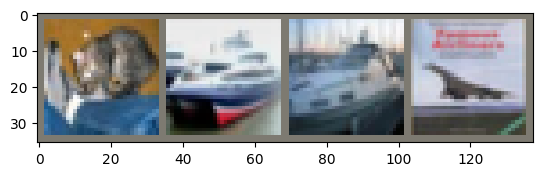

In [3]:
from torch.utils.data.dataset import TensorDataset
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def denorm_imgshow(img, mean=cifar10_mean, std=cifar10_std):
    mean = np.asarray(mean)
    std = np.asarray(std)
    denormalize = transforms.Normalize((-1 * mean / std), (1.0 / std))
    result_img = img.squeeze(0)
    result_img = denormalize(result_img)

    # clip image value between 0 and 1
    result_img = torch.clamp(result_img, 0, 1)
    np_img = result_img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))

# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)
images = images[0:4]
labels = labels[0:4]

# show images and print labels
denorm_imgshow(torchvision.utils.make_grid(images))
print(' '.join('%5s\t' % classes[labels[j]] for j in range(4)))

We checked that data is downloaded properly, and it's time to start implementing our model. In this homework,  we will implement ResNet-50. ResNet is a widely used model, known to solve the vanishing gradient problem which appeared in models with deep network structures, by exploiting residual learning. For detailed explanation, please look up the paper: https://arxiv.org/abs/1512.03385.

### Implementation
ResNet-50 is made up of building blocks called “bottlenecks”. The structure of a building block is as follows:

<div>
<img src="https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F9907E0375CB8A11F0F" width="400"/>
</div>

First implement a building block by filling in the following skeleton code.

- Each weight layer consists of ```conv2d``` - ```batchnorm2d``` - ```relu``` activation
- To match the dimension for residual learning, implement and use the ```self.shortcut``` in the skeleton code.
- The number 1 and 3 in the figure indicates kernel sizes.
- For first and last ```conv2d``` layer, fix the stride to 1. For the second ```conv2d``` layer, stride is determined by input.

In [4]:
import torch
import torch.nn as nn

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, channels, stride=1):
        super(Bottleneck, self).__init__()
        # TODO
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(channels)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(channels)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(channels, self.expansion*channels, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(self.expansion * channels)
        )
        self.relu = nn.ReLU()

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion*channels:
            # TODO
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion*channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*channels)
            )

    def forward(self, x):
        # TODO
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.conv3(out)
        out += self.shortcut(x)
        out = self.relu(out)
        return out


With the bottleneck block, we will implement ResNet-50 with the blocks. The structure of ResNet-50 is in the following table (3rd column):
![table](https://user-images.githubusercontent.com/68190553/117823565-9345b100-b2a8-11eb-8b06-cfbe5511b053.png)


Implementation details:
- First layer (the ```conv1``` in the table) is made up of  ```conv2d``` layer with kernel size 7, channel 64, and stride 2, (and set padding to 3) followed by a ```batchnorm2d``` layer.
- ```conv2_x```, ```conv3_x```,  ```conv4_x```,  ```conv5_x``` layer consists of the bottleneck blocks, with different number of channels.
- There should be a ```MaxPool2d``` layer before  ```conv2_x``` with kernel size 3 and stride 2, padding 1.
- For ```conv2_x```, set stride to 1. For ```conv3_x```,  ```conv4_x```, ```conv5_x``` set stride to 2.
- The output after ```conv5_x``` should pass average pooling, and a fully connected layer. Use ```torch.nn.AdaptiveAvgPool2d``` for average pooling and  ```nn.Linear``` for fully connected layer.
- You do not have to implement softmax. (In training, we will use cross entropy loss)


In [5]:
class ResNet50(nn.Module):
    def __init__(self, num_blocks=[3,4,6,3], num_classes=10):
        super().__init__()
        # TODO
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2_x = self._make_layer(Bottleneck, 64, num_blocks[0], stride=1)
        self.conv3_x= self._make_layer(Bottleneck, 128, num_blocks[1], stride=2)
        self.conv4_x= self._make_layer(Bottleneck, 256, num_blocks[2], stride=2)
        self.conv5_x = self._make_layer(Bottleneck, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * Bottleneck.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self,x):
        # TODO
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


As we finished building the model, we will implement optimizer and criterion for training. The details are as follows:
- SGD optimizer (you can change and test with different parameters if you want). Use ```torch.optim.SGD``` for implementation.
- cross entropy loss (as this is a classification task) Use ```torch.nn.CrossEntropyLoss``` for implementation.

In [9]:
model = ResNet50()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)

We will move on to training our model with the data loaded above. For each training epoch, the following has to be done:

- Get data (batches), load images and labels from the data. Use the ```trainloader``` in the skeleton code.
- Set parameter gradients to zero. Use ```optimizer.zero_grad()```.
- Feedforward data to get the model output.
- Compute losses, and do backpropagation for optimization. Use ```loss.backward()``` and ```optimizer.step()```.

You may add additional functions to print or plot the losses.

In [10]:
for epoch in range(50): # you may change the number of epoches depending on the learning rate
    # TODO
    model.train()
    running_loss = 0.0
    total_data = 0

    for idx, data in enumerate(trainloader):
        # TODO
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        total_data += labels.size(0)

    print('[Epoch: %d] loss: %.3f' %(epoch+1, running_loss / total_data))

[Epoch: 1] loss: 0.030
[Epoch: 2] loss: 0.016
[Epoch: 3] loss: 0.014
[Epoch: 4] loss: 0.013
[Epoch: 5] loss: 0.012
[Epoch: 6] loss: 0.012
[Epoch: 7] loss: 0.011
[Epoch: 8] loss: 0.011
[Epoch: 9] loss: 0.010
[Epoch: 10] loss: 0.010
[Epoch: 11] loss: 0.009
[Epoch: 12] loss: 0.010
[Epoch: 13] loss: 0.009
[Epoch: 14] loss: 0.008
[Epoch: 15] loss: 0.008
[Epoch: 16] loss: 0.008
[Epoch: 17] loss: 0.007
[Epoch: 18] loss: 0.007
[Epoch: 19] loss: 0.007
[Epoch: 20] loss: 0.007
[Epoch: 21] loss: 0.007
[Epoch: 22] loss: 0.007
[Epoch: 23] loss: 0.007
[Epoch: 24] loss: 0.007
[Epoch: 25] loss: 0.007
[Epoch: 26] loss: 0.006
[Epoch: 27] loss: 0.006
[Epoch: 28] loss: 0.006
[Epoch: 29] loss: 0.006
[Epoch: 30] loss: 0.006
[Epoch: 31] loss: 0.006
[Epoch: 32] loss: 0.006
[Epoch: 33] loss: 0.006
[Epoch: 34] loss: 0.006
[Epoch: 35] loss: 0.006
[Epoch: 36] loss: 0.006
[Epoch: 37] loss: 0.006
[Epoch: 38] loss: 0.006
[Epoch: 39] loss: 0.006
[Epoch: 40] loss: 0.006
[Epoch: 41] loss: 0.006
[Epoch: 42] loss: 0.006
[

Evaluate the trained model with testing dataset. The overall process is similar with training the model, except that (1) the model is in evaluation mode, (2) the ```autograd``` is turned off.

In [11]:
model.eval()  # this changes the model's mode into evaluation mode
with torch.no_grad(): # turn off autograd
    # TODO
    test_loss = 0
    correct = 0
    total = 0
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Loss: %.3f | Accuracy: %d %%' % (
        test_loss / len(testloader), 100 * correct / total))


Test Loss: 0.879 | Accuracy: 70 %


### Result Report

Once you finish the implementation, write the results in this colab file. The results should include:
- results of the training loss per epoch (doesn't have to print/plot the results for every epoches. Printing/plotting within a certain frequency is fine)
- results (losses) for evaluation
- accuracy of classification in percentage for evaluation. Note: The accuracy percentage would not affect your grade. That is, regardless of the accuracy percentage value, you will get your grade if you measure and write on your report.

You may do additional experiments (e.g., changing parameters, etc) but this will not affect your grade, which means there will be no points on additional experiments.  
